<h1>
<center>
Assignment 3: Classification: GDA and SVM
</center>
</h1>
<center>
CS 4262/5262 - Foundations of Machine Learning<br>
Vanderbilt University, Spring 2023<br>
Due: Check Brightspace
</center>
<hr>
<br>This assignment will focus on Gaussian Discriminant Analysis and Support Vector Machines. In addition to programming tasks, there are short-answer questions throughout the notebook. 

Contact: Quan Liu quan.liu@vanderbilt.edu for any clarifying questions.

### Please enter your name: Mary Stirling Brown

In [1]:
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import scipy as sp
from sklearn import datasets
from sklearn.svm import SVC 
import pandas as pd
import random
# add package here if needed 

In [2]:
# The following code will plot the decision boundary on a dataset for a given classifier. 
# source: https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch02/ch02.ipynb
def plot_decision_regions_gda(X, y, classifier, resolution=0.02):

    # set up marker generator and color map
    markers = ('s', 'o', 'x', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
 
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(0, xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.xlabel("Citric Acid")
    plt.ylabel("Total Sulfur Dioxide")
    plt.title("Gaussian Discriminative Analysis for Wine")
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        hits = np.where(y == cl)
        for i in hits[0]:
            plt.scatter(x=X[i, 0], 
                    y=X[i, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl,
                    edgecolor='black')

---
## Part 1: Gaussian Discriminant Analysis

The following questions relate to Gaussian Discriminant Analysis (GDA). 

**Task 1**
- Write a function (or a set of functions) that takes in a set of training data and returns the maximum likelihood estimates of the parameters $\mu_0$, $\mu_1$, $\Sigma$, and $\phi_y$. Assume that the class covariance matrices are equal, which results in a linear decision boundary. You can use the formulas provided in the lecture notes for the maximum likelihood estimates of each parameter (i.e., no need to derive those from scratch). 

- Load the Wine dataset (the same files as Assignment2 are included in this distribution). Choose columns of citric acid and total sulfur dioxide as input X. 
- Splitting into training/test sets in 80/20 ratio. Fit the GDA parameters on the training set.
- Try to plot out the 2 fit 2d Gaussian distributions with 2d scatter plot of red wine and white wine.
- Calculate and report the model performance on test set (your accuracy should be above 80%).

In [3]:
# TODO - write functions to calculate the GDA parameters, and estimate these parameters on the wine dataset.
class GaussianDiscriminant():
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.m = len(self.y)
        
    def get_phi(self):
        sum = 0
        for i in range(self.m):
            if self.y[i] == 1:
                sum += 1
        phi = sum / self.m
        return phi
    
    def get_mu0(self):
        num_sum = 0
        denom_sum = 0
        for i in range(self.m):
            if self.y[i] == 0:
                num_sum += self.X[i, :]
                denom_sum += 1
        mu0 = num_sum / denom_sum
        return mu0
    
    def get_mu1(self):
        num_sum = 0
        denom_sum = 0
        for i in range(self.m):
            if self.y[i] == 1:
                num_sum += self.X[i, :]
                denom_sum += 1
        mu1 = num_sum / denom_sum
        return mu1
    
    def get_sigma(self):
        sigma = np.cov(self.X[:, 0], self.X[:, 1])
        return sigma
    
    def get_parameters(self):
        phi = self.get_phi()
        mu0 = self.get_mu0()
        mu1 = self.get_mu1()
        sigma = self.get_sigma()
        return phi, mu0, mu1, sigma
    
    def predict(self, x):
        phi, mu0, mu1, sigma = self.get_parameters()
        n = x.shape[1]
        m = x.shape[0]
        predictions = []
        
        for i in range(m):
            # p(x | y = {0, 1})
            eq1 = 1 / (np.power(2 * np.pi, n / 2) * np.power(np.linalg.det(sigma), 1/2))
            p_x_y0 = eq1 * np.exp(np.matmul(np.matmul(-1/2 * (x[i, :] - mu0).T, np.linalg.inv(sigma)), x[i, :] - mu0))
            p_x_y1 = eq1 * np.exp(np.matmul(np.matmul(-1/2 * (x[i, :] - mu1).T, np.linalg.inv(sigma)), x[i, :] - mu1))

            # p(y)
            p_y0 = 1 - phi
            p_y1 = phi

            # p(x | y)p(y)
            p0 = p_x_y0 * p_y0
            p1 = p_x_y1 * p_y1
            
            # get larger probability
            if p0 > p1:
                predictions.append(0)
            else:
                predictions.append(1)
        predictions = np.array(predictions)
        return predictions
    
    def accuracy(self, y, predictions):
        m = len(predictions)
        correct = 0
        for i in range(m):
            if y[i] == predictions[i]:
                correct += 1
        accuracy = correct / m * 100
        return accuracy

In [4]:
'''
Partitions a dataset into a training set and a test set (80/20 split, respectively). 
Shuffles dataset before splitting. 
@param x - data inputs (numpy.ndarray)
       y - data targets (numpy.ndarray)
@return training set inputs, 
        training set targets, 
        test set inputs,
        test set targets (all numpy.ndarray)
'''
def split_train_test(x, y):
    xy = list(zip(x, y))
    random.shuffle(xy)
    x, y = zip(*xy)
    
    split = int(len(x)*0.8)
    train_x = np.array(x[:split])
    train_y = np.array(y[:split])
    test_x = np.array(x[split:])
    test_y = np.array(y[split:])
    
    train_y = np.reshape(train_y, (len(train_y),1))
    test_y = np.reshape(test_y, (len(test_y),1))
    
    return train_x, train_y, test_x, test_y

In [5]:
# Load the wine dataset with columns citric avid and total sulfur dioxide as the features
wine = pd.read_csv('C:\\Users\\marys\\OneDrive\\Documents\\MachineLearning\\cs4262-5262-2023S\\Assignment2\\assignment2-wine_quality.csv')
x_wine = wine[["citric acid", "total sulfur dioxide"]].to_numpy()
y_wine = wine["label"].to_numpy()

# Splitting into training/test sets in 80/20 ratio
train_x, train_y, test_x, test_y = split_train_test(x_wine, y_wine)

gda = GaussianDiscriminant(train_x, train_y)

predictions = gda.predict(test_x)

accuracy = gda.accuracy(test_y, predictions)
print(f"Accuracy on test data is {accuracy}%")

Accuracy on test data is 85.9375%


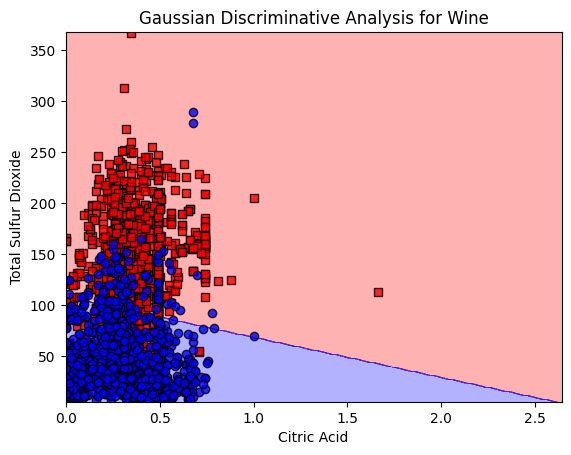

In [6]:
plot_decision_regions_gda(train_x, train_y, gda, resolution=0.02)

**Question 1:** Report the values of these parameters.

In [7]:
phi, mu0, mu1, sigma = gda.get_parameters()
print(f"\u03C6: {phi}")
print(f"\u03Bc0: {mu0}")
print(f"\u03Bc1: {mu1}")
print(f"\u03A3: {sigma}")

φ: 0.5001953888237592
μ0: [  0.36341673 144.15832682]
μ1: [ 0.26560156 46.31796875]
Σ: [[3.10890186e-02 2.78559356e+00]
 [2.78559356e+00 3.90275195e+03]]


**Question 2:** In which scenario(s) is GDA expected to outperform logistic regression, and vice versa? 

GDA makes stronger assumptions about the data than logistic regression.  Logistic regression is better for incorrect modeling assumptions. Thus, GDA outperfroms logistic regression when the modeling assumptions are correct, so it is more data efficient in that it takes less training data. GDA will outperform logistic regression when p(x|y) is a gaussian with shared $\Sigma$. Logistic regression outperforms GDA when the assumptions about the data are incorrect since it is less sensitive to modeling assumptions. Logistic regression especially outperforms GDA when the data is non-Gaussian.

**Question 3:** Show that when we assume that the class covariance matrices are equal, the GDA decision boundary is linear. You can type your derivation here using LaTeX notation, or if you prefer to write it by hand, you can upload a pdf or photo.

---
## Part 2: Support Vector Machine

Now, you will apply a Support Vector Machine (with radial basis function kernel) to the [Wisconsin Breast Cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html). Use the columns 'perimeter (mean)' and 'symmetry (mean)' for the input features in your calculations. Here, rather than writing your own SVM class, you will be calling functions provided in scikit-learn: [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

**Question 4:** Why is feature scaling important when using a support vector machine with the RBF kernel?

The RBF kernel involves calculating the Euclidean norm. This measures the distance between the input x with the hyperplane z. Without doing feature scaling, one feature with a large range of values could throw off this Euclidean norm without knowing which feature input threw off the calculation. Thus, by doing feature scaling it brings the features to the same scale. Thus, this eliminates any bias towards any particular features, no matter if the features have a large or small range of values. 

**Task 2**
<br><br>Using the WBC dataset, shuffle the dataset, split it using a 80/20  train/test partition, and perform feature scaling. You may refer to your code from Assignment 2 for those steps. Refer to instructions regarding feature scaling in the Logistic Regression section of Assignment 2.

In [8]:
# Standardizing the breast cancer data to mean = 0 and variance = 1
def standardization(train_x, test_x):
    for i in range(train_x.shape[1]):
        mean = train_x[:,i].mean()
        variance = train_x[:,i].std()
        train_x[:, i]  = (train_x[:, i] - mean) / variance
        test_x[:, i]  = (test_x[:, i] - mean) / variance
    return train_x, test_x

In [9]:
#TODO - process and partition the data 
x, y = datasets.load_breast_cancer(return_X_y = True, as_frame = True)

X = x[["mean perimeter", "mean symmetry"]].to_numpy()

# split it into 80/20 train/test partition
train_x, train_y, test_x, test_y = split_train_test(X, y)

# feature scaling
train_x, test_x = standardization(train_x, test_x)
train_y = train_y.reshape((455,))

**Question 5:** In the context of scikit-learn's SVM implementation (linked above), explain what hyperparameters C and gamma are, and describe the effects of increasing and decreasing their values.

C is the regularization parameter, where the strenght of regularization is inversely proportional to C. Thus, the hyperparameter C  must be positive. C balances the smoothness of the decision boundary while accurately classifying training points. The larger the C, the more training points will be classified correctly, but it leads to overfitting.  The smaller the C, the smoother the decision boundary as it becomes more linear, but less training points may be correctly calculated. Gamma is the kernel coefficient for our rbf kernel. It must be non-negative for floats. More specifically, gamma specifies how much a single training point influences the decision boundary. High values of gamma means that the decision boundary is dependent on training points close to the line, which leads far away points being ignored. This leads to a less-linear decision boundary. Low values of gamma means that far away points from the decision boundary carry weight, resulting in a more linear decision boundary.

**Task 3**

You will implement k-fold cross-validation to select the SVM hyperparameters. Note: you must write k-fold CV yourself, do not use sklearn.model_selection.KFold. However, you may use scikit-learn's SVC (you don't need to implement support vector machine yourself).

- Choose three values of C and three values of gamma that you wish to consider. Additionally, pick a value of _k_ (# of cross-validation folds) 
- For each pair of hyperparameter values (C, gamma), perform k-fold cross validation *within the training set* you designated above.  
- Report the pair of hyperparameter values that yields the highest accuracy (averaged across the k iterations) on this k-fold CV.
- Using that pair of hyperparameters, train a "final" SVM using the *entire* training set
- Run and report the accuracy of this model on the held-out test set. 

In [10]:
def get_accuracy(test_y, pred_y):
    correct = 0
    for i in range(len(pred_y)):
        if test_y[i] == pred_y[i]:
            correct += 1
    accuracy = correct / len(pred_y)
    return accuracy

In [11]:
#TODO - k-fold cross validation on SVMs
k = 5
train_x_split = np.array_split(train_x, k)
train_y_split = np.array_split(train_y, k)
test_x_split = np.array_split(test_x, k)
test_y_split = np.array_split(test_y, k)

train_xs, train_ys, test_xs, test_ys = {}, {}, {}, {}

for i in range(k):
    train_xs["x{0}".format(i + 1)] = train_x_split[i]
    train_ys["y{0}".format(i + 1)] = train_y_split[i]

ks = {}

for i in range(k):
    indices = [1, 2, 3, 4, 5]
    indices.remove(i + 1)
    ks["k{0}".format(i + 1)] = [np.concatenate((train_xs["x{0}".format(indices[0])], train_xs["x{0}".format(indices[1])], 
                                                train_xs["x{0}".format(indices[2])], train_xs["x{0}".format(indices[3])])),
                                np.concatenate((train_ys["y{0}".format(indices[0])], train_ys["y{0}".format(indices[1])],
                                                train_ys["y{0}".format(indices[2])], train_ys["y{0}".format(indices[3])]))]

C = [1, 10, 100]
gamma = [0.1, 0.01, 0.001]
accuracy = 0

for c in C:
    for g in gamma:
        sum_accs = 0
        for i in range(k):
            svm = SVC(C = c, gamma = g)
            svm.fit(ks["k{0}".format(i + 1)][0], ks["k{0}".format(i + 1)][1])
            pred_y = svm.predict(train_xs["x{0}".format(i + 1)])
            new_accuracy = get_accuracy(train_ys["y{0}".format(i + 1)], pred_y)
            sum_accs += new_accuracy
        sum_accs = sum_accs / k
        if sum_accs > accuracy:
            accuracy = new_accuracy
            best_c = c
            best_g = g

print(f"Best pair of hyperparameters for k-fold cv:")
print(f"\t C = {best_c}")
print(f"\t gamma = {best_g}")
print(f"Averaged accuracy across k-iterations for this pair is {accuracy * 100}%")

print(f"\nUsing this pair of hyperparameters on the entire training set:")
final_svm = SVC(C = best_c, gamma = best_g)
final_svm.fit(train_x, train_y)
pred_y = svm.predict(test_x)
final_acc = get_accuracy(test_y, pred_y) * 100
print(f"Final accuracy is {final_acc}%")

Best pair of hyperparameters for k-fold cv:
	 C = 100
	 gamma = 0.001
Averaged accuracy across k-iterations for this pair is 85.71428571428571%

Using this pair of hyperparameters on the entire training set:
Final accuracy is 89.47368421052632%


**Question 6:** Which pair of hyperparameters were selected by k-fold CV? What was the accuracy of the corresponding model on the held-out test set?

The hyperparameters selected by k-fold CV are: C = 100 and gamma = 0.001. The averaged accuracy on the held-out test set was 85.71%. The final accuracy on the test set after training the entire training set on this pair of hyperparameters was 89.47%.

**Question 7:** Discuss the effects of changing C and gamma. To illustrate your response, generate plots of the decision boundary resulting from different values of C and gamma, in the following way:

The larger the C, the more curvy the decision boundary becomes as it is trying to classify more training input accurately. The smaller the C, the more linear the line becomes. The larger the gamma, the more curvy the decision boundary becomes. The smaller the gamma, the more linear the line becomes. Thus, the best gamma and C value provide a balance between these differences that result in the best accuracy for the training data without overfitting.

- Using the 'best' value of C (selected based on k-fold CV above), sweep over 2-3 different values of gamma, generating one plot of the decision boundary (superimposed on the training points) each time. Use the entire training set.
- Repeat the above, this time using the 'best' value of gamma (selected based on k-fold CV above) and sweeping over 2-3 different values of C.

In [12]:
# The following code will plot the decision boundary on a dataset for a given classifier. 
# source: https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch02/ch02.ipynb
def plot_decision_regions(X, y, classifier, c, g, resolution=0.02):

    # set up marker generator and color map
    markers = ('s', 'o', 'x', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.xlabel("Perimeter (mean)")
    plt.ylabel("Symmetry (mean)")
    title = "SVM with c = " + str(c) + " and gamma = " + str(g)
    plt.title(title)
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        hits = np.where(y == cl)
        for i in hits[0]:
            plt.scatter(x=X[i, 0], 
                    y=X[i, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl,
                    edgecolor='black')
    plt.show()

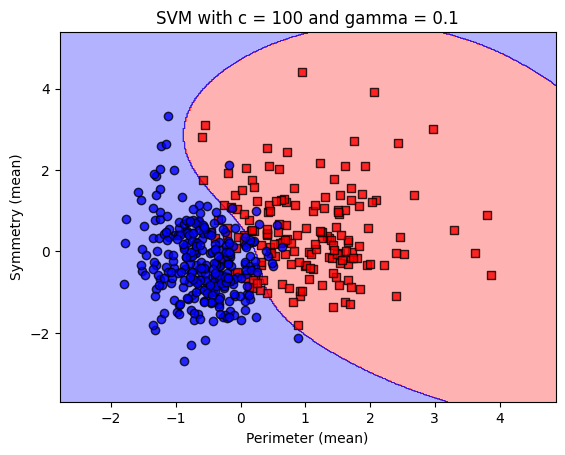

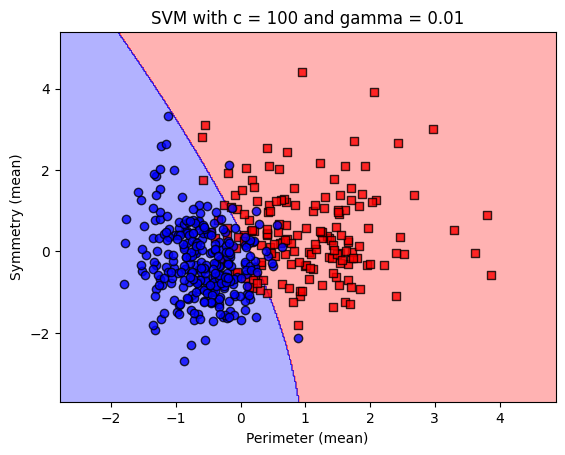

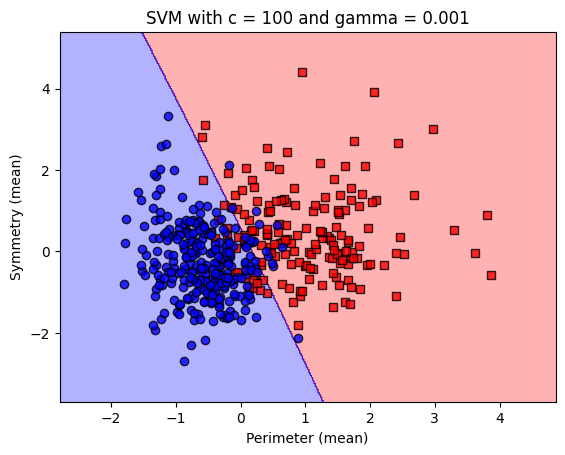

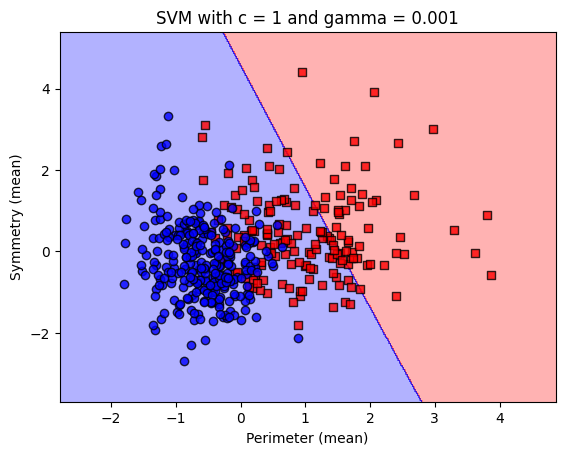

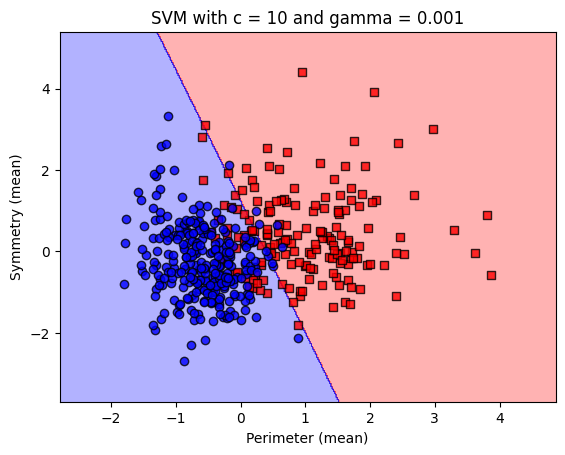

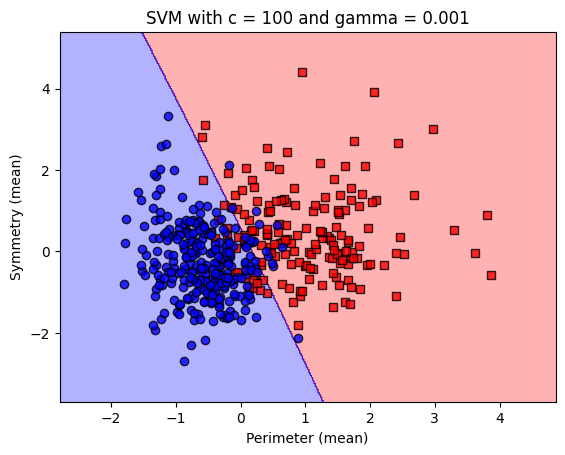

In [13]:
#TODO - analyze the effects of C and gamma

for g in gamma:
    svm_item = SVC(C = best_c, gamma = g)
    svm_item.fit(train_x, train_y)
    plot_decision_regions(train_x, train_y, svm_item, best_c, g)
    
for c in C:
    svm_item = SVC(C = c, gamma = best_g)
    svm_item.fit(train_x, train_y)
    plot_decision_regions(train_x, train_y, svm_item, c, best_g)


---
## Part 4: Submission 

Please upload a clean version of your work to Brightspace by the deadline. <em>If you use a separate PDF with your short answer questions, it should be added alongside the ipynb file as a PDF, and zipped up together as your solution.</em>

Below, please acknowledge your collaborators as well as any resources/references (beyond guides to Python syntax) that you have used in this assignment:

https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989#:~:text=SVM%20or%20Support%20Vector%20Machine,separates%20the%20data%20into%20classes.